### 1.Load data

Load dataset on COVID perturbed cells from Stephenson_2021 reandomly subsampled to 3000 cells from scGEN  package

In [1]:
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')
adata = sc.read_h5ad('../stephenson_2021_3000subsampled.h5ad')
adata

AnnData object with n_obs × n_vars = 2878 × 16299
    obs: 'Collection_Day', 'Swab_result', 'condition', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'author_cell_type', 'organism', 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'cell_type', 'dataset_group'
    var: 'gene_id', 'gene_name'
    uns: 'log1p', 'umap'
    obsm: 'X_scVI', 'X_umap'

In [16]:
adata = sc.AnnData(adata.X, obs=adata.obs.copy(), var=adata.var.copy())
adata.obs_names_make_unique()
print(adata)
print('\n', adata.obs['condition'].value_counts())
print('\n', adata.obs['author_cell_type'].value_counts())
print('\n', adata.obs['condition'].value_counts())

AnnData object with n_obs × n_vars = 2878 × 16299
    obs: 'Collection_Day', 'Swab_result', 'condition', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'author_cell_type', 'organism', 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'cell_type', 'dataset_group'
    var: 'gene_id', 'gene_name'

 condition
Covid      2323
Healthy     555
Name: count, dtype: int64

 author_cell_type
NK_16hi                  397
CD4.CM                   333
CD4.Naive                270
CD8.TE                   221
B_naive                  203
CD83_CD14_mono           195
CD14_mono                178
CD8.Naive                174
CD4.Tfh                  108
CD4.IL22                  86
CD8.EM                    77
gdT                       69
CD16_mono                 61
Platelets                 58
MAIT                      56
NK_56hi                   51
B_switched_memory         43
R

### 2.Build and train models

In [31]:
from scpram import models
model = models.SCPRAM(input_dim=adata.n_vars, device='cpu:0')
model = model.to(model.device)
# key_dic varies with the adata
key_dic = {'condition_key': 'condition',
           'cell_type_key': 'author_cell_type',
           'ctrl_key': 'Healthy',
           'stim_key': 'Covid',
           'pred_key': 'pred',
           }
cell_to_pred = 'CD14_mono'
# The training set does not contain the type of data to be predicted after the perturbation
train = adata[~((adata.obs[key_dic['cell_type_key']] == cell_to_pred) &
               (adata.obs[key_dic['condition_key']] == key_dic['stim_key']))]
model.train_SCPRAM(train, epochs=100)

Training Epoch 99: 100%|██████████| 100/100 [06:08<00:00,  3.68s/it, SCPRAM_loss=258, kl_loss=822, recon_loss=516]


### 3.Predict

In [4]:
adata_to_pred = adata[((adata.obs[key_dic['cell_type_key']] == cell_to_pred) &
                       (adata.obs[key_dic['condition_key']] == key_dic['ctrl_key']))]
pred = model.predict(train_adata=train,
                     cell_to_pred=cell_to_pred,
                     key_dic=key_dic,
                     ratio=0.005)  # The ratio need to vary with the size of dataset
print(pred)

AnnData object with n_obs × n_vars = 16 × 16299
    obs: 'Collection_Day', 'Swab_result', 'condition', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'author_cell_type', 'organism', 'sex', 'tissue', 'ethnicity', 'disease', 'assay', 'cell_type', 'dataset_group'
    var: 'gene_id', 'gene_name'


### 4.Evaluation

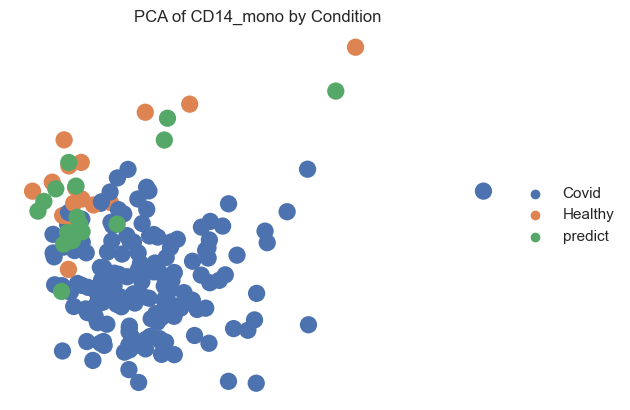

common DEGs:  1


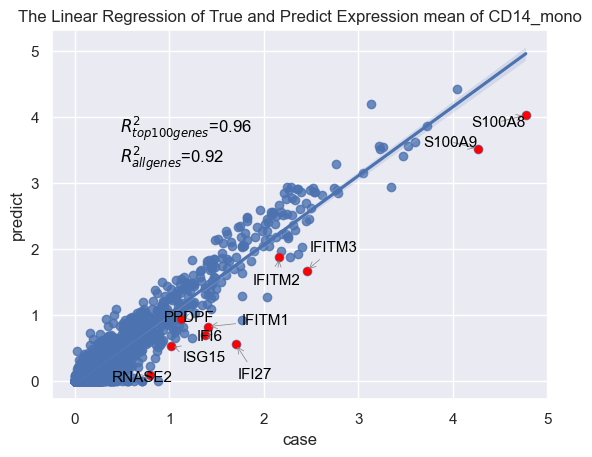

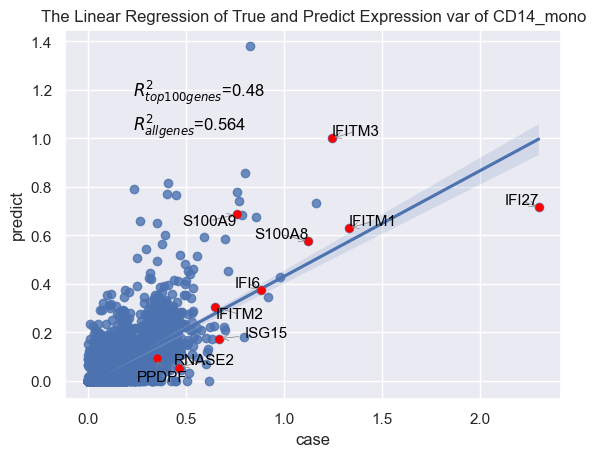

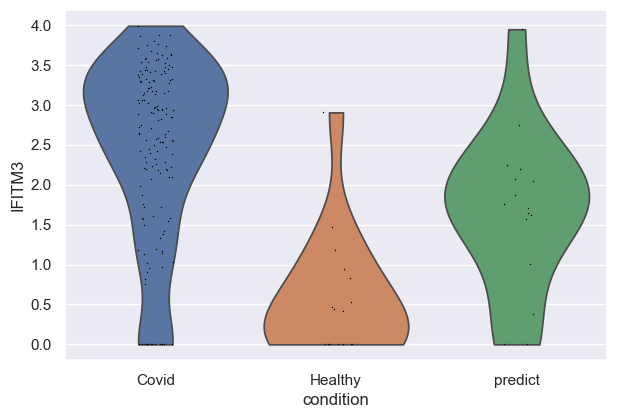

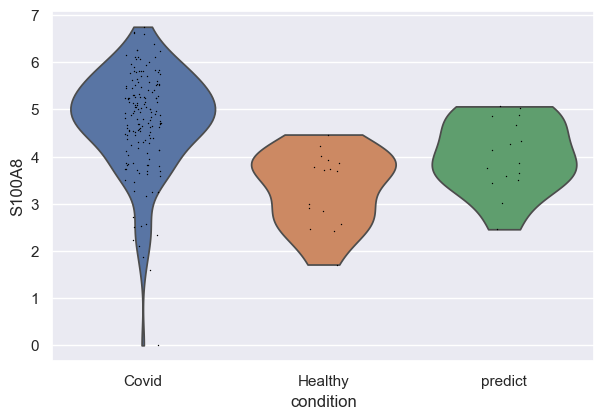

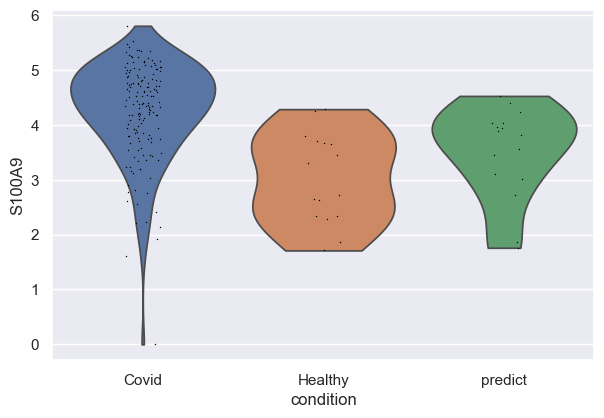

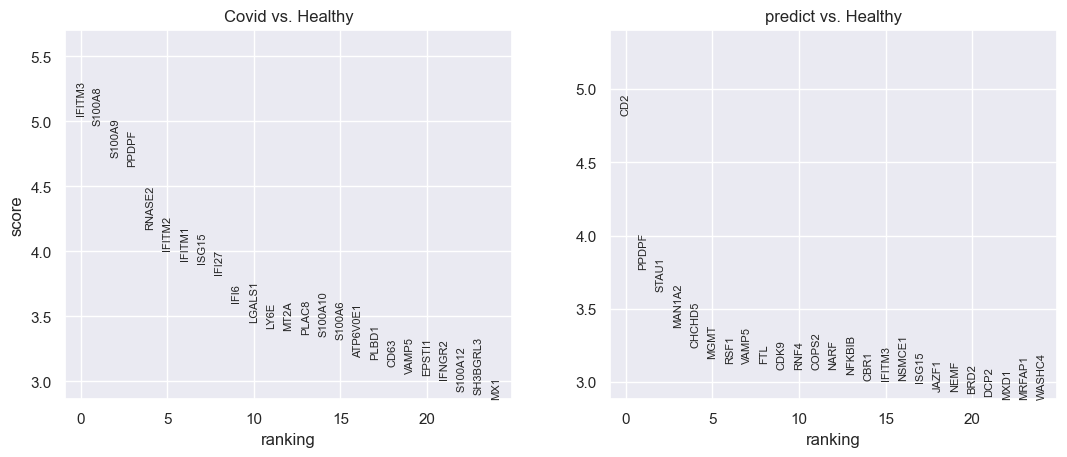

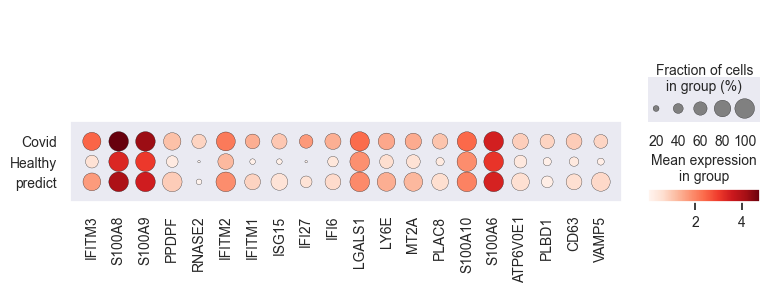

Expression data is present in eval_adata.X


In [30]:
# from scpram import evaluate
ground_truth = adata[(adata.obs[key_dic['cell_type_key']] == cell_to_pred)]
eval_adata = ground_truth.concatenate(pred)
# Replace NaN values with zero
eval_adata_noninf = eval_adata.copy()
eval_adata_noninf.X = np.nan_to_num(eval_adata_noninf.X)

evaluate_adata(eval_adata=eval_adata_noninf, 
                        cell_type=cell_to_pred, 
                        key_dic=key_dic
                        )

if eval_adata.X is not None:
    print("Expression data is present in eval_adata.X")
else:
    print("No expression data found in eval_adata.X")

# Save the eval_adata object to an .h5ad file
eval_adata.write("exported_eval_adata.h5ad")
